In [97]:
#!pip install yfinance --upgrade
#!pip install talib-binary
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
#!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd ta-lib
#!./configure --prefix=/usr
#!make
#!make install
#!pip install Ta-Lib

In [98]:
import os
import sys
import copy
import datetime
import time
import itertools

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import talib as ta
from talib import MA_Type

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
#import own data manipulation toolkit
#sys.path.append('/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data')
#import _datatoolkit as dtk

**Defining Data Folder Structures**

In [101]:
#data folder structures
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
backtest_output_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/backtest_output'

**1) Define Tickers List, Backtest Date Range and Data Retrival Intervals**

In [102]:
# define list of tickers to backtest
#ticker_list = ['ARCC', 'STAG', 'O', 'WPC', 'MAIN', 'ABR', 'ACRE', 'DIVO', 'JEPI', 'LTC', 'OHI', 'PFLT', 'QYLD', 'SCHD', 'STOR', 'XRMI', 'TQQQ', 'TSLA', 'AAPL', 'GLD', 'SLV', 'GDX']
ticker_list = ['IRM', 'WPC', 'UVXY', 'SQQQ', 'MOS', 'ARCC', 'HTGC', 'ACRE', 'ABR', 'CTO', 'O', 'IBM']
#ticker_list = ['AAPL', 'GOOG', 'AMZN', 'IBM', 'MU', 'GLD', 'SLV', 'QQQ', 'IWM', 'GME']

# define date range
start_date = '2021-03-20'
end_date = '2022-12-31'
interval = '1d'

# initial capital in USD
initial_capital = 8000

# position sizing
pos_size = round(initial_capital/len(ticker_list),2)

**2) Getting OHLC Data from Yahoo Finance** </b>


*   Get stock data based on ticker list from Yahoo Finance
*   Create each stock data as different dataframe
*   Add Technical Analysis indicators from TA-Lib
*   Pointing working directory to data folder, export dach dataframe as independent csv file 





In [103]:
# changing working directory to data folder's path
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
os.chdir(data_folder)

# getting OHLC data from yfinance package, if auto_adjust=True, OHLC data will not have adj close column, use progress=False to get rid of comments
# Other indicators: 14 day RSI
for ticker in ticker_list:
  try:
    globals()[ticker] = pd.DataFrame
    globals()[ticker] = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True, back_adjust=True, progress=False)
    globals()[ticker]['100EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=100)
    globals()[ticker]['200EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=200) 
    globals()[ticker]['ATR'] = ta.ATR(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['RSI'] = ta.RSI(globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    globals()[ticker]['BBand_U'], globals()[ticker]['BBand_M'], globals()[ticker]['BBand_L'] = ta.BBANDS(globals()[ticker]['Close']) # if add exponential smoothing, matype=MA_Type.T3

    # Stochastic indicators
    globals()[ticker]['Stoch_slowk'], globals()[ticker]['Stoch_slowd'] = ta.STOCH(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'],\
                                                                         fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    # Generating Ichimoku Cloud Indicators
    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    globals()[ticker]['IC_per_26H'] = globals()[ticker]['High'].rolling(window=26).max()
    globals()[ticker]['IC_per_26L'] = globals()[ticker]['Low'].rolling(window=26).max()
    globals()[ticker]['IC_base'] = ((globals()[ticker]['IC_per_26H'] + globals()[ticker]['IC_per_26L'])/2)

    # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
    globals()[ticker]['IC_per_9H'] = globals()[ticker]['High'].rolling(window=9).max()
    globals()[ticker]['IC_per_9L'] = globals()[ticker]['Low'].rolling(window=9).max()
    globals()[ticker]['IC_conv'] = (globals()[ticker]['IC_per_9H'] + globals()[ticker]['IC_per_9L'])/2

    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    globals()[ticker]['IC_span_a'] = ((globals()[ticker]['IC_base'] + globals()[ticker]['IC_conv'])/2).shift(26)
    
    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    globals()[ticker]['IC_per_52H'] = globals()[ticker]['High'].rolling(window=52).max()
    globals()[ticker]['IC_per_52L'] = globals()[ticker]['Low'].rolling(window=52).max()
    globals()[ticker]['IC_span_b'] = ((globals()[ticker]['IC_per_52H'] + globals()[ticker]['IC_per_52L'])/2).shift(26)
    
    # add/drop columns and clean up
    globals()[ticker] = globals()[ticker].drop(['Volume', 'MACD_hist'], axis=1)
    globals()[ticker] = globals()[ticker].round(4).dropna()
    globals()[ticker] = globals()[ticker].reset_index()
    globals()[ticker]['Position'] = 0
    globals()[ticker][['Equity Value', 'MDD_dollar', 'PNL', 'Holding Period', 'Win Count']] = np.NAN
    
    #writing each ticker dataframe into separate .csv files, save to google drive
    #globals()[ticker].to_csv(ticker+'.csv', index=False, header=True)
  except:
    print(globals()[ticker])

**Other Optional Indicators:** </b>

**MACD_hist** - globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9) </b>

**ADX** - globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>


**ADXR** - globals()[ticker]['ADXR'] = ta.ADXR(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>

**50 Day Exponential Moving Average** - globals()[ticker]['50EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=50) </b>

**3) Building the DataFrame List, Perform Backtesting**

In [104]:
#df_list = [ARCC, STAG, O, WPC, MAIN, ABR, ACRE, DIVO, JEPI, LTC, OHI, PFLT, QYLD, SCHD, STOR, XRMI, TQQQ, TSLA, AAPL, GLD, SLV, GDX]
df_list = [IRM, WPC, UVXY, SQQQ, MOS, ARCC, HTGC, ACRE, ABR, CTO, O, IBM]
#df_list = [AAPL, GOOG, AMZN, IBM, MU, GLD, SLV, QQQ, IWM, GME]

**Back Testing** </b>


*   Backtesting of Trade Logic across all tickers and in the designated timeframe
*   Backtesting for Trade strategy with simulated PNL



In [105]:
# function to extract dataframe name
def get_df_name(df):
   name =[x for x in globals() if globals()[x] is df][0]
   return name

In [106]:
# defining the global list for storing output
global macdrsi_trade_list
macdrsi_trade_list = []

global macdema_trade_list
macdema_trade_list = []

global ic_trade_list
ic_trade_list = []

global bbrsi_trade_list
bbrsi_trade_list = []

pos_size = round(initial_capital/len(ticker_list),2)

3.1) Trade Strategy - MACD + RSI



*   Entry - MACD crosses over signal line + RSI < 45
*   Exit - MACD crosses below signal line or RSI > 70



In [107]:
def backtest_macdrsi(df):
  df_name = get_df_name(df)
  pos_opened = False
  open_price  = 0
  close_price = 0
  hold_counter = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  initial_buy_price = 0
  win_counter = 0
  stop_loss = initial_equity_value * 0.85
  profit_target = initial_equity_value * 1.06

  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_rsi         = df.loc[i, 'RSI']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_MACD > now_MACD_signal) and (now_rsi < 45)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      initial_buy_price = initial_equity_value/ lot_size
      hold_counter = hold_counter + 1
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
      macdrsi_trade_list.append([now_date, df_name, open_price, pos_opened, lot_size, initial_equity_value])
    
    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif ((pos_opened == True) and (now_MACD < now_MACD_signal)) or \
      ((pos_opened == True) and (now_rsi > 70)) or \
      ((pos_opened == True) and (now_date == df.loc[(len(df)-1), 'Date'])) and (now_open*lot_size < stop_loss):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = round(((close_price - initial_buy_price) * lot_size) - sell_commission,2)
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl.round(2)
      df.loc[i, 'Holding period'] = hold_counter
      if pnl > 0:
        win_counter += 1
      pnl_list.append(pnl)
      macdrsi_trade_list.append([now_date, df_name, close_price, pos_opened, lot_size, (close_price*lot_size), pnl, hold_counter])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      initial_buy_price = 0
      lot_size = 0
      stop_loss = 0
      hold_counter = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - round(initial_equity_value,2)
      hold_counter = hold_counter + 1
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].max().round(2)
  avg_hold_period = df['Holding period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

3.2) Trade Strategy - MACD EMA </br>


*   Entry - MACD > signal + price > 200 EMA
*   Exit - MACD < signal + price < 200 EMA
*   Risk Rward Ratio at 1 : 1.5






In [108]:
def backtest_macdema(df):
  df_name = get_df_name(df)
  pos_opened = False
  open_price  = 0
  close_price = 0
  hold_counter = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  initial_buy_price = 0
  win_counter = 0
  stop_loss = initial_equity_value * 0.8
  profit_target = initial_equity_value * 1.3

  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_100EMA      = df.loc[i, '100EMA']
    now_200EMA      = df.loc[i, '200EMA']
    now_rsi         = df.loc[i, 'RSI']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_MACD > now_MACD_signal) and (now_open > now_200EMA) and (now_100EMA > now_200EMA)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      initial_buy_price = initial_equity_value/ lot_size
      hold_counter = hold_counter + 1
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
      macdema_trade_list.append([now_date, df_name, open_price, pos_opened, lot_size, initial_equity_value])
    
    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif ((pos_opened == True) and ((now_MACD < now_MACD_signal) or (now_open < now_200EMA))) or \
      ((pos_opened == True) and (now_date == df.loc[(len(df)-1), 'Date'])):
#      ((pos_opened == True) and (now_open*lot_size < stop_loss)) or \
#      ((pos_opened == True) and (now_open*lot_size > profit_target)):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = round(((close_price - initial_buy_price) * lot_size) - sell_commission,2)
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl.round(2)
      df.loc[i, 'Holding period'] = hold_counter
      if pnl > 0:
        win_counter += 1
      pnl_list.append(pnl)
      macdema_trade_list.append([now_date, df_name, close_price, pos_opened, lot_size, (close_price*lot_size), pnl, hold_counter])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      initial_buy_price = 0
      lot_size = 0
      stop_loss = 0
      hold_counter = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - round(initial_equity_value,2)
      hold_counter = hold_counter + 1
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].max().round(2)
  avg_hold_period = df['Holding period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

3.3) Trade Strategy - MACD Stochastic </br>


*   Entry - STOCH oversold exist before MACD > signal + MACD cross-over 
*   Exit - STOCH > 80 + MACD < signal 
*   Risk Rward Ratio at 1 : 1.5






3.4) Trade Strategy - Ichimoku Cloud </br>


*   Entry - price > 200 EMA and & span a + conversion line > baseline 
*   Exit - price < 200 EMA or span b + conversion line < baseline
*   Stop loss > baseline






In [109]:
def backtest_ic(df):
  df_name = get_df_name(df)
  pos_opened = False
  open_price  = 0
  close_price = 0
  hold_counter = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  initial_buy_price = 0
  win_counter = 0
  stop_loss = initial_equity_value * 0.8
  profit_target = initial_equity_value * 1.3

  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_200EMA      = df.loc[i, '200EMA']
    now_ic_conv     = df.loc[i, 'IC_conv']
    now_ic_base     = df.loc[i, 'IC_base']
    now_ic_span_a   = df.loc[i, 'IC_span_a']
    now_ic_span_b   = df.loc[i, 'IC_span_b']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_ic_conv > now_ic_base) and (now_open > now_ic_span_a)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      initial_buy_price = initial_equity_value/ lot_size
      hold_counter = hold_counter + 1
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
      ic_trade_list.append([now_date, df_name, open_price, pos_opened, lot_size, initial_equity_value])
    
    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif (pos_opened == True) and ((now_ic_conv < now_ic_base) or (now_open < now_ic_span_b)):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = round(((close_price - initial_buy_price) * lot_size) - sell_commission,2)
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl.round(2)
      df.loc[i, 'Holding period'] = hold_counter
      if pnl > 0:
        win_counter += 1
      pnl_list.append(pnl)
      ic_trade_list.append([now_date, df_name, close_price, pos_opened, lot_size, (close_price*lot_size), pnl, hold_counter])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      initial_buy_price = 0
      lot_size = 0
      stop_loss = 0
      hold_counter = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - round(initial_equity_value,2)
      hold_counter = hold_counter + 1
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].max().round(2)
  avg_hold_period = df['Holding period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

3.5) Trade Strategy - Bollinger Bands + Stochastic Indicators </br>


*   Entry - price < lower BBands + Stochastic < 20 
*   Exit - price > upper BBands = Stochastic > 80
*   Stop Loss at price below lower Bollinger Bands





In [110]:
def backtest_bbstoch(df):
  df_name = get_df_name(df)
  pos_opened = False
  open_price  = 0
  close_price = 0
  hold_counter = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  initial_buy_price = 0
  win_counter = 0
  stop_loss = now_BBand_L > now_open
  profit_target = initial_equity_value * 1.06

  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_BBand_U     = df.loc[i, 'BBand_U']
    now_BBand_L     = df.loc[i, 'BBand_L']
    now_Stoch_slowk = df.loc[i, 'Stoch_slowk']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_open > now_BBand_L) and (now_Stoch_slowk <30)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      initial_buy_price = initial_equity_value/ lot_size
      hold_counter = hold_counter + 1
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
      bbrsi_trade_list.append([now_date, df_name, open_price, pos_opened, lot_size, initial_equity_value])
    
    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif (pos_opened == True) and ((now_open < now_BBand_U) and (now_Stoch_slowk > 70)) or \
      ((pos_opened == True) and (now_date == df.loc[(len(df)-1), 'Date'])) and stop_loss:
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = round(((close_price - initial_buy_price) * lot_size) - sell_commission,2)
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl.round(2)
      df.loc[i, 'Holding period'] = hold_counter
      if pnl > 0:
        win_counter += 1
      pnl_list.append(pnl)
      bbrsi_trade_list.append([now_date, df_name, close_price, pos_opened, lot_size, (close_price*lot_size), pnl, hold_counter])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      initial_buy_price = 0
      lot_size = 0
      stop_loss = 0
      hold_counter = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - round(initial_equity_value,2)
      hold_counter = hold_counter + 1
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].max().round(2)
  avg_hold_period = df['Holding period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

**4) Projecting Total PNL** </br>


*   Creating for loop to simulate PNL based on particular strategy
*   Calculate portfolio PNL, ROI etc.



In [111]:
ic_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    ic_test_result = backtest_ic(df)
    ic_result_list.append(ic_test_result)

    ic_result_df = pd.DataFrame(ic_result_list)
    ic_result_list.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    print(df_name, '- no trade signal')

IRM - no trade signal
WPC - no trade signal
UVXY - no trade signal
SQQQ - no trade signal
MOS - no trade signal
ARCC - no trade signal
HTGC - no trade signal
ACRE - no trade signal
ABR - no trade signal
CTO - no trade signal
O - no trade signal
df - no trade signal


In [112]:
macdema_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    test_result = backtest_macdema(df)
    macdema_result_list.append(test_result)

    macdema_result_df = pd.DataFrame(macdema_result_list)
    macdema_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    print(df_name, '- no trade signal')

UVXY - no trade signal


In [113]:
# PNL for MACD EMA Strategy

measure_date = df_list[1].loc[1, 'Date']
end_date = df_list[1].loc[df.index[-1], 'Date'] 
print('Trading Strategy: MACD + 200 EMA')
print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((macdema_result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
MDD = macdema_result_df['Maximum Drawdown'].mean().round(2)
print('Total No of Trades Executed:', (macdema_result_df['No of Trade'].sum()))
print('Total PNL: USD', macdema_result_df['Total PNL'].sum().round(2))
print('Required Capital: USD', initial_capital)
print('ROI: ', ROI, '%')
print('Avg Win Rate: ', macdema_result_df['Win Rate %'].mean().round(2), '%')
macdema_result_df.sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)


Trading Strategy: MACD + 200 EMA
Trade period: 2022-01-04 to 2022-12-02
Total No of Trades Executed: 85
Total PNL: USD 695.52
Required Capital: USD 8000
ROI:  8.69 %
Avg Win Rate:  48.86 %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days,Win Rate %
3,MOS,12,204.99,17.08,352.91,8.58,50.00
0,IRM,11,204.98,18.63,100.49,9.73,45.45
9,O,6,114.47,19.08,86.13,14.67,33.33
8,CTO,10,93.52,9.35,95.30,10.50,50.00
1,WPC,11,73.66,6.70,93.83,10.00,63.64
5,HTGC,4,66.56,16.64,44.99,11.75,100.00
10,df,8,64.15,8.02,51.93,7.25,62.50
4,ARCC,5,59.29,11.86,57.52,13.20,80.00
6,ACRE,5,50.10,10.02,91.25,11.60,20.00
7,ABR,8,-46.68,-5.84,13.81,4.50,12.50


In [118]:
bbstoch_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    test_result = backtest_bbstoch(df)
    bbstoch_result_list.append(test_result)

    bbrsi_result_df = pd.DataFrame(bbstoch_result_list)
    bbrsi_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    print(df_name, '- no trade signal')

IRM - no trade signal
WPC - no trade signal
UVXY - no trade signal
SQQQ - no trade signal
MOS - no trade signal
ARCC - no trade signal
HTGC - no trade signal
ACRE - no trade signal
ABR - no trade signal
CTO - no trade signal
O - no trade signal
df - no trade signal


In [115]:
# PNL for Bollinger Bands RSI Strategy
try:
  measure_date = df_list[1].loc[1, 'Date']
  end_date = df_list[1].loc[df.index[-1], 'Date'] 
  print('Trading Strategy: Bollinger Bands + RSI')
  print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
  ROI = ((bbrsi_result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
  MDD = bbrsi_result_df['Maximum Drawdown'].mean().round(2)
  print('Total No of Trades Executed:', (bbrsi_result_df['No of Trade'].sum()))
  print('Total PNL: USD', bbrsi_result_df['Total PNL'].sum().round(2))
  print('Required Capital: USD', initial_capital)
  print('ROI: ', ROI, '%')
  print('Avg Win Rate: ', bbrsi_result_df['Win Rate %'].mean().round(2), '%')
  bbrsi_result_df.sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)
except:
  print('Trading Strategy: Bollinger Bands + RSI')
  print('No trade signals/ transactions')

Trading Strategy: Bollinger Bands + RSI
Trade period: 2022-01-04 to 2022-12-02
Trading Strategy: Bollinger Bands + RSI
No trade signals/ transactions


In [116]:
macdrsi_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    macdrsi_test_result = backtest_macdrsi(df)
    macdrsi_result_list.append(macdrsi_test_result)

    macdrsi_result_df = pd.DataFrame(macdrsi_result_list)
    macdrsi_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except: 
    print(df_name, '- no trade signal')

In [117]:
# PNL for MACD RSI Strategy

measure_date = df_list[1].loc[1, 'Date']
end_date = df_list[1].loc[df.index[-1], 'Date'] 
print('Trading Strategy: MACD + RSI')
print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((macdrsi_result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
MDD = macdrsi_result_df['Maximum Drawdown'].mean().round(2)
print('Total No of Trades Executed:', (macdrsi_result_df['No of Trade'].sum()))
print('Total PNL: USD', macdrsi_result_df['Total PNL'].sum().round(2))
print('Required Capital: USD', initial_capital)
print('ROI: ', ROI, '%')
print('Avg Win Rate: ', macdrsi_result_df['Win Rate %'].mean().round(2), '%')
macdrsi_result_df.sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)


Trading Strategy: MACD + RSI
Trade period: 2022-01-04 to 2022-12-02
Total No of Trades Executed: 37
Total PNL: USD 1750.27
Required Capital: USD 8000
ROI:  21.88 %
Avg Win Rate:  68.61 %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days,Win Rate %
3,SQQQ,1,383.59,383.59,405.84,9.17,100.00
8,ABR,5,232.22,46.44,161.60,7.38,40.00
2,UVXY,3,223.45,74.48,418.17,19.33,66.67
6,HTGC,4,200.95,50.24,192.51,13.50,50.00
1,WPC,4,156.49,39.12,102.33,12.23,75.00
4,MOS,3,147.04,49.01,352.91,9.79,66.67
5,ARCC,3,122.00,40.67,97.92,16.14,66.67
7,ACRE,4,92.97,23.24,103.69,16.57,50.00
11,df,4,83.42,20.86,82.61,8.27,75.00
10,O,1,80.60,80.60,89.93,17.29,100.00


**5) Detailed Portfolio Transaction List**

In [ ]:
global macdrsi_trade_list
macdrsi_trade_list = []

global macdema_trade_list
macdema_trade_list = []

In [122]:
# full trading transactions across everything
macdrsi_full_trade = pd.DataFrame(macdrsi_trade_list)
macdrsi_full_trade.columns = ['Transaction Date', 'Ticker', 'Buy/Sell Price', 'Trade Opened', 'Lot Size', 'Ttl Equity Value', 'PNL', 'Holding Days']

In [123]:
macdrsi_full_trade.head()

,Transaction Date,Ticker,Buy/Sell Price,Trade Opened,Lot Size,Ttl Equity Value,PNL,Holding Days
0,2022-02-08,IRM,43.5770,True,15.0,653.5100,NaN,NaN
1,2022-02-15,IRM,42.6708,False,15.0,640.0620,-14.06,5.0
2,2022-06-29,IRM,48.2981,True,13.0,627.7500,NaN,NaN
3,2022-07-13,IRM,46.5283,False,13.0,604.8679,-23.42,9.0
4,2022-07-26,IRM,46.4690,True,14.0,650.4300,NaN,NaN


In [124]:
trade_plot = macdrsi_full_trade[['Transaction Date', 'Ttl Equity Value', 'PNL']]

Text(0.5, 1.0, 'Total Equity Value for the Trading Period')

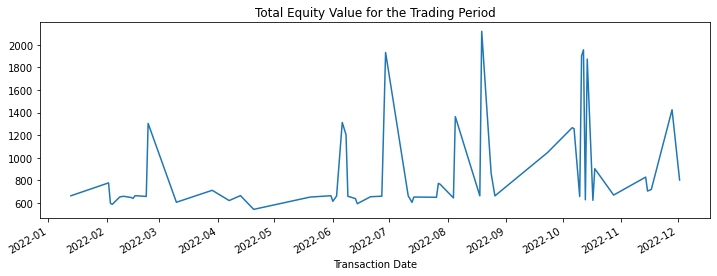

In [125]:
# graph plot - full year total equity value
trade_plot.groupby('Transaction Date')['Ttl Equity Value'].sum().plot(figsize=(12,4))
plt.title('Total Equity Value for the Trading Period')

In [127]:
# Class to call Pandas by row and column
# https://stackoverflow.com/questions/28754603/indexing-pandas-data-frames-integer-rows-named-columns 
class XLocIndexer:
    def __init__(self, frame):
        self.frame = frame
    
    def __getitem__(self, key):
        row, col = key
        return self.frame.iloc[row][col]

pd.core.indexing.IndexingMixin.xloc = property(lambda frame: XLocIndexer(frame))

Appendix - Ichimoku Cloud </br>
https://stackoverflow.com/questions/28477222/python-pandas-calculate-ichimoku-chart-components </br>

1) Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2)) </br>
- period9_high = pd.rolling_max(high_prices, window=9) </br>
- period9_low = pd.rolling_min(low_prices, window=9) </br>
- tenkan_sen = (period9_high + period9_low) / 2 </br>

2) Kijun-sen (Base Line): (26-period high + 26-period low)/2)) </br>
- period26_high = pd.rolling_max(high_prices, window=26) </br>
- period26_low = pd.rolling_min(low_prices, window=26) </br>
- kijun_sen = (period26_high + period26_low) / 2 </br>

3) Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2)) </br>
- senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26) </br>

4) Senkou Span B (Leading Span B): (52-period high + 52-period low)/2)) </br>
- period52_high = pd.rolling_max(high_prices, window=52) </br>
- period52_low = pd.rolling_min(low_prices, window=52) </br>
- senkou_span_b = ((period52_high + period52_low) / 2).shift(26) </br>
